<a href="https://colab.research.google.com/github/arun-kmr-singh/Image-Noise-Reduction-using-Autoencoders-in-Tensorflow/blob/master/Implemetation%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Denoising with Autoencoders

## Task 1: Introduction and Importing Libraries
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [6]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

## Task 2: Data Preprocessing
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [7]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

## Task 3: Adding Noise
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [9]:
x_train_noisy = x_train + np.random.rand(60000,784)*0.9   # 0.9 is multiplied to it for scaling so that values don't go much larger.
x_test_noisy = x_test + np.random.rand(10000,784)*0.9

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


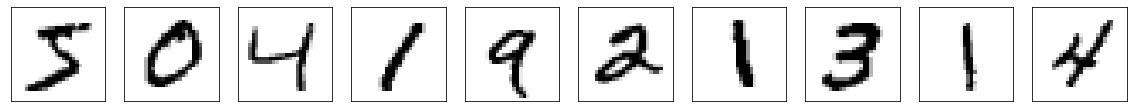

In [12]:
def plot(x, p, labels=False):
  plt.figure(figsize=(20,2))
  for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x[i].reshape(28,28), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    if labels:
      plt.xlabel(np.argmax(p[i]))
  plt.show()

plot(x_train, None)

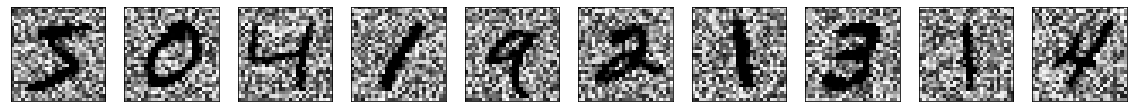

In [13]:
plot(x_train_noisy, None)

## Task 4: Building and Training a Classifier
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

## Task 5: Building the Autoencoder
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

## Task 6: Training the Autoencoder
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

## Task 7: Denoised Images
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

## Task 8: Composite Model
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___